In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import savgol_filter, find_peaks
import fly_analysis as fa

In [2]:
def filter_trajecs(
    df,
    min_length=300,  # 50 frames = 0.5 seconds
    max_z_speed=0.3,  # shouldn't be flying up/down a lot
    min_speed=0.05,  # should be flying (not wallking)
):
    selected_obj_ids = []

    for obj_id, gdf in df.groupby("obj_id"):
        if len(gdf) > min_length:
            speed = np.linalg.norm(np.vstack([gdf.zvel, gdf.xvel, gdf.yvel]), axis=0)

            if gdf.z.min() > 0.05:  # not on floor
                if gdf.z.max() < 0.5:  # not on ceiling
                    if np.max(np.abs(gdf.zvel)) < max_z_speed:
                        if np.min(speed[5:]) > min_speed:  # first few frames are off
                            selected_obj_ids.append(obj_id)

    return df.loc[df["obj_id"].isin(selected_obj_ids)]


def angdiff(theta1, theta2):
    return np.arctan2(np.sin(theta1 - theta2), np.cos(theta1 - theta2))


def get_saccade_amplitude(xvel, yvel, idx):
    heading_before = np.arctan2(yvel[idx - 10], xvel[idx - 10])
    heading_after = np.arctan2(yvel[idx + 10], xvel[idx + 10])
    heading_difference = angdiff(heading_before, heading_after)
    return heading_difference


def process_fly_trajectories(
    df,
    x_bounds=(-0.25, 0.25),
    y_bounds=(-0.25, 0.25),
    z_bounds=(0.00, 0.35),
    min_trajectory_length=300,
):
    angvels = []
    linvels = []
    accels = []
    amplitudes = []
    isi = []
    for obj_id, grp in df.groupby("unique_obj_id"):
        if len(grp) < min_trajectory_length:
            continue

        # make a clone of grp
        grp_new = grp.copy()

        # find indices in range
        x, y, z = grp.x.to_numpy(), grp.y.to_numpy(), grp.z.to_numpy()
        indices_in_range = (
            (x >= x_bounds[0])
            & (x <= x_bounds[1])
            & (y >= y_bounds[0])
            & (y <= y_bounds[1])
            & (z >= z_bounds[0])
            & (z <= z_bounds[1])
        )
        grp_new = grp_new.iloc[indices_in_range]

        # split dataframes
        result = split_on_jumps(grp_new, column="frame", k=1)
        x = savgol_filter(result[0]["x"], 21, 3)
        y = savgol_filter(result[0]["y"], 21, 3)
        z = savgol_filter(result[0]["z"], 21, 3)
        xvel = savgol_filter(result[0]["xvel"], 21, 3)
        yvel = savgol_filter(result[0]["yvel"], 21, 3)

        # angular velocity
        theta = np.arctan2(yvel, xvel)
        theta_u = np.unwrap(theta)
        angular_velocity = np.gradient(theta_u, 0.01)

        # linear velocity
        linear_velocity = np.sqrt(xvel**2 + yvel**2)

        # linear acceleration
        linear_acceleration = np.gradient(linear_velocity, 0.01)

        # saccade indices
        saccades = detect_saccades(angular_velocity, threshold=500, distance=10)

        # loop over saccade indices
        for sac in saccades:
            if sac - 25 < 0 or sac + 25 > len(angular_velocity):
                continue

            angvels.append(angular_velocity[sac - 25 : sac + 25])
            linvels.append(linear_velocity[sac - 25 : sac + 25])
            accels.append(linear_acceleration[sac - 25 : sac + 25])
            amplitudes.append(get_saccade_amplitude(xvel, yvel, sac))
        isi.append(np.diff(saccades))

    return (
        np.asarray(angvels),
        np.asarray(linvels),
        np.asarray(accels),
        np.asarray(amplitudes),
        isi,
    )

In [3]:
def plot_mean_and_std(data):
    npdata = np.asarray(data)
    fig = plt.figure()
    mean = np.nanmean(npdata, axis=0)
    std = np.nanmean(npdata, axis=0)
    plt.plot(mean)
    plt.fill_between(np.arange(len(mean)), mean - std, mean + std, alpha=0.5)
    plt.show()


def plot_all_traces(data):
    fig = plt.figure()
    for d in data:
        plt.plot(d)
    plt.show()

In [4]:
files = ["20240702_140401.braidz", "20240712_153309.braidz", "20240715_171206.braidz"]
root_folder = "/home/buchsbaum/mnt/DATA/Experiments/"
wtcs = fa.braidz.read_multiple_braidz(files, root_folder)

Reading /home/buchsbaum/mnt/DATA/Experiments/20240702_140401.braidz using pyarrow
Reading /home/buchsbaum/mnt/DATA/Experiments/20240712_153309.braidz using pyarrow
Reading /home/buchsbaum/mnt/DATA/Experiments/20240715_171206.braidz using pyarrow


In [74]:
def split_on_jumps(df, column="frame", k=1, n=300):
    # Calculate the differences between consecutive values
    diffs = df[column].diff()

    # Find indices where the difference is greater than k
    split_indices = diffs[diffs > k].index

    # Initialize result list
    result = []
    
    # If there are split points, perform the splitting
    if not split_indices.empty:
        start_idx = 0
        for idx in split_indices:
            # Slice the DataFrame between the last split index and the current one
            chunk = df.iloc[start_idx:idx]
            if len(chunk) > n:  # Keep only if the chunk has more than 'n' rows
                result.append(chunk)
            start_idx = idx
        
        # Append the remaining portion of the DataFrame after the last split
        chunk = df.iloc[start_idx:]
        if len(chunk) > n:
            result.append(chunk)
    else:
        result = [df]  # No split, just return the original DataFrame
    
    return result

def get_angular_velocity(df):
    theta = np.arctan2(df.yvel, df.xvel)
    theta_u = np.unwrap(theta)
    return np.gradient(theta_u, 0.01)


def get_linear_velocity(df):
    return np.sqrt(df.xvel**2 + df.yvel**2)


def detect_saccades(df):
    peaks, _ = find_peaks(
        df.angular_velocity.abs(), height=np.deg2rad(1000), distance=10
    )
    saccades = np.zeros(len(df), dtype=bool)
    saccades[peaks] = True
    return saccades


def smooth_columns(df):
    for col in ["x", "y", "z", "xvel", "yvel", "zvel"]:
        df[f"{col}_raw"] = df[col]
        df[col] = savgol_filter(df[col], 21, 3)
    return df

def find_nearest_saccade_after_stim(df, stim_idx, min_frames=25, max_frames=45):
    if np.isnan(stim_idx):
        return np.nan
    
    saccade_indices = df.index[
        df['saccade'] & 
        (df.index > stim_idx) & 
        (df.index >= stim_idx + min_frames) & 
        (df.index <= stim_idx + max_frames)
    ].tolist()
    
    if not saccade_indices:
        return np.nan
    
    nearest_saccade_idx = min(saccade_indices, key=lambda x: x - stim_idx)

    return nearest_saccade_idx

def extract_all_saccades(df: pd.DataFrame, stim_idx: float, n_frames: int = 25, k: int = 5):
    def extract_saccade_window(sac_idx):
        start_idx = sac_idx - n_frames
        end_idx = sac_idx + n_frames - 1  # -1 because we want to include the saccade frame
        
        # Check for overflow
        if start_idx < df.index[0] or end_idx > df.index[-1]:
            return None
        
        saccade_window = df.loc[start_idx:end_idx+1]
            
        return saccade_window

    # Find all saccade indices
    all_saccade_indices = df.index[df['saccade']].tolist()
    
    # Extract stimulus-elicited saccade if it exists
    stim_saccade = None
    if not np.isnan(stim_idx):
        stim_saccade = extract_saccade_window(int(stim_idx))
        # Remove stim_idx from all_saccade_indices if it's there
        all_saccade_indices = [idx for idx in all_saccade_indices if idx != int(stim_idx)]
    
    # Extract spontaneous saccades
    spontaneous_saccades = [extract_saccade_window(idx) for idx in all_saccade_indices]
    
    return spontaneous_saccades, stim_saccade

In [88]:

angvels = []
linvels = []
is_stim_saccade = []

df = wtcs["df"]
stim = wtcs["stim"]
break_flag = False

for idx, row in stim.iterrows():
    obj_id = row.obj_id
    frame = row.frame
    exp_num = row.exp_num

    # make a clone of grp
    grp_new = df[(df.obj_id == obj_id) & (df.exp_num == exp_num)]

    # initial checks
    if len(grp_new) < 150:
        continue

    # smooth
    grp_new = smooth_columns(grp_new)

    # calculate and append angvel, linvel, detected saccades
    grp_new["angular_velocity"] = get_angular_velocity(grp_new)
    grp_new["linear_velocity"] = get_linear_velocity(grp_new)
    grp_new["saccade"] = detect_saccades(grp_new)

    # remove out of bounds positions
    grp_new = grp_new[
        (grp_new.x >= -0.1)
        & (grp_new.x <= 0.1)
        & (grp_new.y >= -0.1)
        & (grp_new.y <= 0.1)
        & (grp_new.z >= 0.05)
        & (grp_new.z <= 0.3)
        & (grp_new.linear_velocity >= 0.01)
    ]
    
    # split into groups
    grp_new_split = split_on_jumps(grp_new, column="frame", k=1, n=300)

    # loop over groups
    for i_subgroup, subgrp in enumerate(grp_new_split):
        stim_idx = np.where(subgrp['frame'].values == frame)[0]
        if len(stim_idx) == 0:
            stim_idx = np.nan
        else:
            stim_idx = stim_idx[0]

        x = subgrp['x'].values
        y = subgrp['y'].values
        angular_velocity = subgrp['angular_velocity'].values
        linear_velocity = subgrp['linear_velocity'].values
        saccades = np.where(subgrp['saccade'].values)[0]

        try:
            stim_sac = [sac for sac in saccades if 25<sac-stim_idx<45][0]
        except IndexError:
            stim_sac = np.nan

        # loop over saccades
        for sac in saccades:
            if sac - 25 < 0 or sac + 25 >= len(angular_velocity):
                continue
            angvels.append(angular_velocity[sac - 25 : sac + 25])
            linvels.append(linear_velocity[sac - 25 : sac + 25])
            if sac == stim_sac:
                is_stim_saccade.append(True)
            else:
                is_stim_saccade.append(False)

        # fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))
        # axs[0].plot(x, y)
        # axs[0].scatter(x[saccades], y[saccades], color='red', marker='x')
        # axs[0].scatter(x[0], y[0], color='black', marker='s')
        
        # axs[1].plot(angular_velocity)
        # axs[1].scatter(saccades, angular_velocity[saccades], color='red')
        
        # axs[2].plot(linear_velocity)
        # axs[2].scatter(saccades, linear_velocity[saccades], color='red')

        # if not np.isnan(stim_sac):
        #     axs[2].scatter(stim_sac, linear_velocity[stim_sac], color='green', marker='*', s=100)
        #     axs[0].scatter(x[stim_sac], y[stim_sac], color='green', marker='*', s=100)
        #     axs[1].scatter(stim_sac, angular_velocity[stim_sac], color='green', marker='*', s=100)
            
        # plt.tight_layout()
        # plt.savefig(f"Figures/{obj_id}_{frame}_{exp_num}_{i_subgroup}.png")
        # plt.close('all')


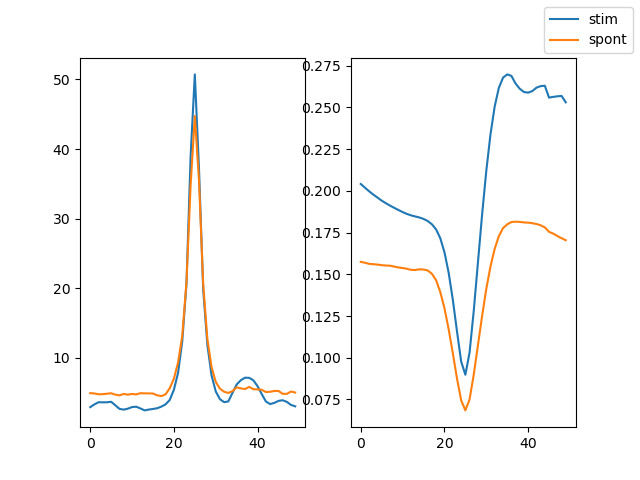

In [89]:
is_stim_saccade = np.asarray(is_stim_saccade, dtype=bool)
angvels = np.abs(np.asarray(angvels))
linvels = np.abs(np.asarray(linvels))

stim_angvels = angvels[is_stim_saccade]
stim_linvels = linvels[is_stim_saccade]

spont_angvels = angvels[~is_stim_saccade]
spont_linvels = linvels[~is_stim_saccade]

mean_stim_angvels = np.nanmean(stim_angvels, axis=0)
mean_spont_angvels = np.nanmean(spont_angvels, axis=0)

mean_stim_linvel = np.nanmean(stim_linvels, axis=0)
mean_spont_linvel = np.nanmean(spont_linvels, axis=0)

fig, axs = plt.subplots(ncols=2, nrows=1)
axs[0].plot(mean_stim_angvels, label="stim")
axs[0].plot(mean_spont_angvels, label="spont")

axs[1].plot(mean_stim_linvel)
axs[1].plot(mean_spont_linvel)

fig.legend()
plt.show()
